##Fine Tuning

In several machine learning applcations, state of the art modles that work on "similar" problems are availabel.

Rather than training a network from scratch, it is worthwhile to use the already available model, albeit they are for a slightly different problem

This is called transfer learning. Possibly the simplest form of transfer learning is Fine-tuning where we make minor adjustments to a network and use it for a new problems.

Fine-tuning is especially effective in cases where limited data is available.

Let's explore example of fine-tunign below. We will fine-tune resent18 trained on imagenet

In [ ]:
!pip install tensorboard

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models,transforms
from torchvision.utils import make_grid
from torchvision.datasets import MNIST
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary


In [ ]:
# MNIST
def mnist(batch_sz, valid_size=0.2, shuffle=True, random_seed=2000):
    num_classes = 10
    transform_train = transforms.Compose([
                        transforms.RandomCrop(28, padding=4),
                        transforms.ToTensor(),
                    ])

    transform_valid = transforms.Compose([
                        transforms.ToTensor(),
                    ])

    transform_test = transforms.Compose([
                        transforms.ToTensor(),
                    ])


    # Training dataset
    train_data = MNIST(root='./datasets', train=True, download=True, transform=transform_train)
    valid_data = MNIST(root='./datasets', train=True, download=True, transform=transform_valid)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    if shuffle == True:
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    train_idx, valid_idx = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_sz, sampler=train_sampler,pin_memory=True)
    valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_sz, sampler=valid_sampler,pin_memory=True)

    # Test dataset
    test_data = MNIST(root='./datasets', train=False, download=True, transform=transform_test)
    test_loader = torch.utils.data.DataLoader(test_data,
                                              batch_size=batch_sz, shuffle=False, pin_memory=True)

    return train_loader, valid_loader, test_loader



In [ ]:
batch_sz=64 # this is batch size i.e. the number of rows in a batch of data
train_loader, valid_loader, test_loader=mnist(batch_sz)

100%|██████████| 9912422/9912422 [00:00<00:00, 246247630.82it/s]


Extracting ./datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./datasets/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 27160469.47it/s]


Extracting ./datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 155567108.98it/s]


Extracting ./datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5774637.40it/s]

Extracting ./datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/MNIST/raw



Adjusting learning rate of group 0 to 1.0000e-02.
Adjusting learning rate of group 0 to 9.0000e-03.
Iterataion 0: Training Loss: 0.278371469932142, Validation Loss: 0.10571582024956849
Iteataion 0: Training Accuracy: 0.9122916666666666, Validation Accuracy  0.96725
Adjusting learning rate of group 0 to 8.1000e-03.
Iterataion 1: Training Loss: 0.09802068936861107, Validation Loss: 0.07202396945739016
Iteataion 1: Training Accuracy: 0.97, Validation Accuracy  0.9789166666666667
Adjusting learning rate of group 0 to 7.2900e-03.
Iterataion 2: Training Loss: 0.06890438195847681, Validation Loss: 0.058477658731738394
Iteataion 2: Training Accuracy: 0.9787916666666666, Validation Accuracy  0.982
Adjusting learning rate of group 0 to 6.5610e-03.
Iterataion 3: Training Loss: 0.055944313640234986, Validation Loss: 0.047079404539622886
Iteataion 3: Training Accuracy: 0.9832083333333334, Validation Accuracy  0.98625
Adjusting learning rate of group 0 to 5.9049e-03.
Iterataion 4: Training Loss: 0.0

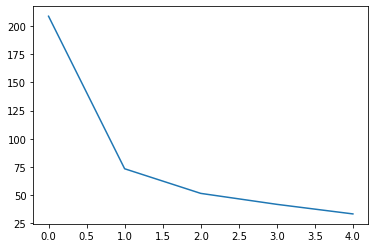

In [ ]:
#Training Resnet from pre-trained weights

#specify a folder under run for tensorboard data for the training
writer = SummaryWriter("runs/lr_1")

device=torch.device('cuda:0')


net=models.resnet18(pretrained=True)
net.conv1=nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
net.fc=nn.Linear (in_features=512, out_features=10, bias=True)

net=net.to(device)
lr=.01
momentum=0.5
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9, verbose=True)


ls=[]
for i in range(5):
  loss_total=0
  loss_val=0
  acc_train=0
  total_train=0
  for ii,batch in enumerate(train_loader):
    data=batch[0]
    label=batch[1]
    #optimizer-->buffer += grad
    optimizer.zero_grad()
    data, label = data.to(device), label.to(device)
    logits = net(data)
    #this is the output of the network and it's shape is batch_size X no of classes
    loss = F.cross_entropy(logits, label)
    loss_total+=loss.item()

    loss.backward()
    optimizer.step()
    out=torch.argmax(logits, dim=1)
    acc_train+=torch.sum(out==label)
    total_train+=logits.shape[0]

  acc_val=0
  total_val=0
  with torch.no_grad():
    for jj,batch in enumerate(valid_loader):
          data=batch[0]
          label=batch[1]
          #optimizer-->buffer += grad
          data, label = data.to(device), label.to(device)
          logits = net(data)
          loss = F.cross_entropy(logits, label)
          loss_val+=loss.item()
          out=torch.argmax(logits, dim=1)
          acc_val+=torch.sum(out==label)
          total_val+=logits.shape[0]



  ls.append(loss_total)
  lr_scheduler.step()
  print(f"Iterataion {i}: Training Loss: {loss_total/ii}, Validation Loss: {loss_val/jj}")
  print(f"Iteataion {i}: Training Accuracy: {acc_train.item()/total_train}, Validation Accuracy  {acc_val.item()/total_val}")
  writer.add_scalar('Loss/train', loss_total/ii, i)
  writer.add_scalar('Loss/test', loss_val/jj, i)
  writer.add_scalar('Accuracy/train', acc_train.item()/total_train, i)
  writer.add_scalar('Accuracy/test', acc_val.item()/total_val, i)
plt.plot(ls)

In [ ]:
#Fine=tuning just the first and last layer

#specify a folder under run for tensorboard data for the training
writer = SummaryWriter("runs/lr_1")

device=torch.device('cuda:0')


net=models.resnet18(pretrained=True)
for layer in net.parameters():
  layer.requires_grad=False
net.conv1=nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
net.fc=nn.Linear (in_features=512, out_features=10, bias=True)

for name,layer in net.named_parameters():
  print(f"layer {name} has requires_grad {layer.requires_grad}")
net=net.to(device)
lr=.01
momentum=0.5
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9, verbose=True)


ls=[]
for i in range(5):
  loss_total=0
  loss_val=0
  acc_train=0
  total_train=0
  for ii,batch in enumerate(train_loader):
    data=batch[0]
    label=batch[1]
    #optimizer-->buffer += grad
    optimizer.zero_grad()
    data, label = data.to(device), label.to(device)
    logits = net(data)
    #this is the output of the network and it's shape is batch_size X no of classes
    loss = F.cross_entropy(logits, label)
    loss_total+=loss.item()

    loss.backward()
    optimizer.step()
    out=torch.argmax(logits, dim=1)
    acc_train+=torch.sum(out==label)
    total_train+=logits.shape[0]

  acc_val=0
  total_val=0
  with torch.no_grad():
    for jj,batch in enumerate(valid_loader):
          data=batch[0]
          label=batch[1]
          #optimizer-->buffer += grad
          data, label = data.to(device), label.to(device)
          logits = net(data)
          loss = F.cross_entropy(logits, label)
          loss_val+=loss.item()
          out=torch.argmax(logits, dim=1)
          acc_val+=torch.sum(out==label)
          total_val+=logits.shape[0]



  ls.append(loss_total)
  lr_scheduler.step()
  print(f"Iterataion {i}: Training Loss: {loss_total/ii}, Validation Loss: {loss_val/jj}")
  print(f"Iteataion {i}: Training Accuracy: {acc_train.item()/total_train}, Validation Accuracy  {acc_val.item()/total_val}")
  writer.add_scalar('Loss/train', loss_total/ii, i)
  writer.add_scalar('Loss/test', loss_val/jj, i)
  writer.add_scalar('Accuracy/train', acc_train.item()/total_train, i)
  writer.add_scalar('Accuracy/test', acc_val.item()/total_val, i)
plt.plot(ls)

In [ ]:
for name,layer in net.named_parameters():
  print(f"{name}has requires_grad {layer.requires_grad}")